In [2]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import LogFormatter

# $\Lambda$-Grey Molasses Cooling

Limitations of Doppler/sideband cooling:

In experiment, $\nu \sim 100kHz$ and $\Gamma \sim 1 - 10 MHz$ hence cooling only occurs far in the unresolved sideband regime.  $\newline$ Hence, need sub-Doppler techniques to cool to motional GS.$\newline$ 


Types of sub-Doppler techniques: (using 2-photon transitions)

1. Polarization Gradient (PG) and Grey Molasses (GM): Uses a single laser frequency counter propagating with diff polarizations, creating a polarization gradient.

     Polarization gradient becomes important because it can directly impact the interaction hamiltonian $ H_I = -\frac{\Omega}{2} (\epsilon(\hat{x}) \bold{D^\dag} + h.c.) $ through the relation,

$$ 
\epsilon(\hat{x})  = \epsilon (0) + \hat{x} \frac{d\epsilon}{dx}  
$$


2. Electromagentically Induced Transparency (EIT) and $\Lambda$-GM: Second laser introduced that couples a different spin state to the excited state; creates dark reservoir states in the process 
    Optical Pumping naturally occurs into the dark states.

3. Raman Sideband Cooling (RSB):
    Uses 2x lasers for a Raman transitions and a 3rd Laser for Optical Pumping using angular momentum selection rules for keeping it dark. (in 2 the state is only dark for specific circumstances)


## The non-effective Hamiltonian approach: Solving for Steady State of the $\Lambda$ system

In [147]:
'''
each of eta, Gamma, Delta are arrays of length 2 (noting coupling between each of 0 and 1 states to 2 state)

Below is for computing ss without using the effective operator formalism
'''
def compute_ss(n_motional,nu,Delta,Gamma,eta, Omega, approx = False): 

    # Extracting the parameters
    Gamma0 = Gamma[0]
    Gamma1 = Gamma[1]

    eta0 = eta[0]
    eta1 = eta[1]

    Delta0 = Delta[0]
    Delta1 = Delta[1]
    
    Omega0 = Omega[0]
    Omega1 = Omega[1]

    # motional state operators
    a = qt.destroy(n_motional)     # Annihilation operator
    a_dag = qt.create(n_motional)  # Creation operator

    # Position operator x 
    x = (a + a_dag) # I ignore units here because we just roll with eta as a parameter rather than worrying about 'k'

    # Identity operators for tensor products
    id_internal = qt.qeye(3)
    id_motional = qt.qeye(n_motional)

    # Define e^(±ikx) operators using the position operator
    def exp_ikx(eta,x):
        
        if approx == True: # simplifies calculation deep into LDR (with \eta << 1)
            return (id_motional + 1j * eta * x)

        exp_x = (1j * eta * x).expm() # I checked that expm works.
        return exp_x

    #Note that we follow a convention - the order is always atomic tensor motional

    # Bright and Dark operators; 0 is bright, 1 is dark
    zero_proj = qt.basis(3, 0).proj()
    one_proj = qt.basis(3, 1).proj()
    ground_proj = zero_proj + one_proj
    
    excited_proj = qt.basis(3, 2).proj()

    D0 = qt.basis(3,0) * qt.basis(3,2).dag()
    D1 = qt.basis(3,1) * qt.basis(3,2).dag()

    #Bright and Dark parameters
    
    Omega_rms = np.sqrt(Omega0**2 + Omega1**2)
    Omega_BD = (Delta1 - Delta0)*Omega0*Omega1/(Omega_rms)**2

    DetlaB = (Omega0**2 * Delta0 + Omega1**2 * Delta1)/(Omega_rms**2)
    DeltaD = (Omega0**2 * Delta1 + Omega1**2 * Delta0)/(Omega_rms**2)    

    ## Hamiltonian in bright and dark basis; 0 is bright, 1 is dark

    H_motional = nu * qt.tensor(id_internal, a_dag * a)

    H_atomic = qt.tensor( 
        DetlaB* qt.fock_dm(3,0) + 
        DeltaD* qt.fock_dm(3,1) + 
        Omega_BD*(qt.basis(3,0) * qt.basis(3,1).dag() + 
                  qt.basis(3,1) * qt.basis(3,0).dag())
    , id_motional)    
 
    H_interaction = (1/(2*Omega_rms)) * (
    qt.tensor(D0.dag() , (Omega0**2)* exp_ikx(eta0,x)+ (Omega1**2)*exp_ikx(eta1,x)) +   # couples bright to excited state
    (Omega0*Omega1)* qt.tensor(D1.dag() , (exp_ikx(eta1,x) - exp_ikx(eta0,x))) 
    )   

    H_interaction = H_interaction + H_interaction.dag()  # completing the interaction Hamiltonian

    H_total = H_motional + H_atomic + H_interaction

    # defining collapse operators
    # collapse operators for emission in positive and negative x-direction (1D)
    D0_orig = (Omega0*D0 - Omega1*D1)/Omega_rms
    D1_orig = (Omega1*D0 + Omega0*D1)/Omega_rms 
    # D0_orig = D0 # I tried scamming, didn't work
    # D1_orig = D1 # I tried scamming, didn't work
    L0_plus = np.sqrt(Gamma0) * qt.tensor(D0_orig,  exp_ikx(eta0,x))
    L0_minus = np.sqrt(Gamma0) * qt.tensor(D0_orig, exp_ikx(-eta0,x))
    L1_plus = np.sqrt(Gamma1) * qt.tensor(D1_orig,  exp_ikx(eta1,x))
    L1_minus = np.sqrt(Gamma1) * qt.tensor(D1_orig, exp_ikx(-eta1,x))
    c_ops = [L0_plus, L0_minus, L1_plus, L1_minus]


    '''
    Rather than using MESolver we try using SSSolver (only interested in long-term behavior of system) - as done in the paper. 

    Get steady state values of the system as a function of diff parameters. 
    '''


    rho_ss = qt.steadystate(H_total, c_ops)

    # Measurement operators
    measure_excited = qt.tensor(excited_proj, id_motional)
    measure_ground2 = qt.tensor(one_proj, id_motional)
    measure_ground1 = qt.tensor(zero_proj, id_motional)
    measure_n = qt.tensor(id_internal, a_dag * a)

    # Compute steady-state expectation values
    excited_pop_ss = qt.expect(measure_excited, rho_ss)
    ground2_pop_ss = qt.expect(measure_ground2, rho_ss)
    ground1_pop_ss = qt.expect(measure_ground1, rho_ss)
    motional_n_ss = qt.expect(measure_n, rho_ss)


    return ground1_pop_ss, ground2_pop_ss, excited_pop_ss, motional_n_ss

In [141]:
#Testing code, to sanity check the compute ss function

n_motional = 10         # Number of motional levels
Gamma = np.array([1e6 , 1e6]) # Spontaneous emission rate (Γ) in Hz
Delta = 10 * Gamma  # Detuning (Δ) in Hz
nu = 0.05*Gamma[0] # Trap frequency (ν) in Hz 

eta = np.array([0.05, -0.05])              #Lamb-dicke parameter
# Eta removes the necessity for defining k because already given
Omega = np.sqrt(nu*Delta)
ground1_pop_ss, ground2_pop_ss, excited_pop_ss, motional_n_ss = compute_ss(n_motional,nu,-Delta,Gamma,eta, Omega)


print("Steady-state excited population:", excited_pop_ss)
print("Steady-state ground1 population:", ground1_pop_ss)
print("Steady-state ground2 population:", ground2_pop_ss)
print("Steady-state average phonon number:", motional_n_ss)

# As expected, most of the population lies in ground2 i.e. dark state

Steady-state excited population: 9.608531584171133e-05
Steady-state ground1 population: 0.025753636199386733
Steady-state ground2 population: 0.9741502784847716
Steady-state average phonon number: 8.79978726785401


## Some results:


#### 1. As we increase $ \Delta$ , $\braket{n}$ decreases with increasing $\nu$.

<img src="images/EIT-1-log.png" alt="Hamiltonian" width="600">

A couple of observations:

1. Cooling follows similar trend as observed in Doppler cooling for 2LS; minima occurs at $\Delta = -\nu $ for red-detuned transitions.   
2. Above plots were gotten at red-detunings of Delta (so $\Delta_0$ is infact negative) but it turns out EIT cooling only occurs at Blue detunings (positive $\Delta_0$) so I'm not sure how this can be reconciled. 

To understand this I need a better intuition for *why* blue or red detuning may be required. Perhaps it's related to light shifts of energy levels?


#### 2. EIT resonance - Scanned around optimal power (i.e. $\Omega_i$) for parameters $\eta = 0.05, \Delta_0 = 10\Gamma, \nu = 0.05 \Gamma$ and $\Omega_0 = \Omega_1 = \sqrt{2\nu\Delta_0}$ 

<img src="images/EIT-1-scan.png" alt="Hamiltonian" width="600">

$\delta = \Delta_0 - \Delta_1$ $\newline$
Here I've used blue-detuned lasers (both) and I find that around $\Omega_0 = \Omega_1 = \sqrt{2\nu\Delta_0}$ we get optimal cooling (again, not sure of physical interpretation, but paper claims that $\newline$ this is to set light shift of bright state = $\frac{\Omega^2}{2\Delta_0} = \nu$ = Trapping frequency

### Generating the plots for a range of parameters:

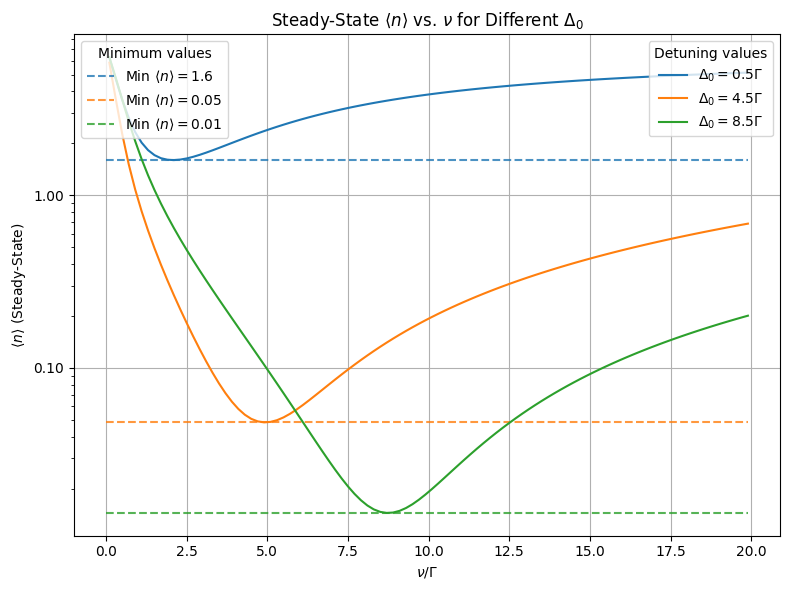

In [ ]:
# EIT - 1D plot of avg_n vs nu
 
n_motional = 15  # Number of motional levels
Gamma = np.array([1e6, 1e6])  # Spontaneous emission rate (Γ) in Hz
eta = np.array([0.05, -0.05])  # Lamb-Dicke parameter

# Parameter ranges
nu_values = np.arange(0.1 * Gamma[0], 20 * Gamma[0], 0.2 * Gamma[0])  # Frequency values
Delta_values = np.arange(0.5 * Gamma[0], 10 * Gamma[0], 4 * Gamma[0])  # Delta[0] values

avg_n = np.zeros((len(Delta_values), len(nu_values)))

for i, Delta0 in enumerate(Delta_values):
    for j, nu in enumerate(nu_values):
        Delta1 = Delta0  
        Delta = np.array([Delta0, Delta1])  # Set Delta[0] and Delta[1]
        Omega = eta*Gamma
        ground1_pop_ss, ground2_pop_ss, excited_pop_ss, motional_n_ss = compute_ss(n_motional, nu, -Delta, Gamma, eta, Omega, False)
        avg_n[i, j] = motional_n_ss  


plt.figure(figsize=(8, 6))
# Default matplotlib colors for consistency
curve_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # blue, orange, green

# Create plot handles for the legend
curve_handles = []
dash_handles = []

for i, Delta0 in enumerate(Delta_values):
    y_values = avg_n[i, :]
    min_idx = np.argmin(y_values)
    min_n = y_values[min_idx]
    
    # Plot main curve with explicit color
    main_line, = plt.plot(nu_values / Gamma[0], y_values,
                          color=curve_colors[i],
                          label=rf'$\Delta_0 = -{Delta0 / Gamma[0]:.1f} \Gamma$')
    curve_handles.append(main_line)
    
    # Dashed line with matching color
    dash_line, = plt.plot([0, max(nu_values / Gamma[0])], [min_n, min_n],
                          linestyle='dashed', color=curve_colors[i], alpha=0.8)
    dash_handles.append(dash_line)

plt.xlabel(r'$\nu / \Gamma$')
plt.ylabel(r'$\langle n \rangle$ (Steady-State)')
plt.title(r"Steady-State $\langle n \rangle$ vs. $\nu$ for Different $\Delta_0$")

# Set y-axis to log scale
plt.yscale('log')

# Use a ticker formatter to display the original values
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.gca().yaxis.get_major_formatter().set_scientific(False)

# First legend for curve lines
first_legend = plt.legend(curve_handles,
                         [h.get_label() for h in curve_handles],
                         loc='upper right', title="Detuning values")
plt.gca().add_artist(first_legend)

# Create second legend for minimum values
min_values = [avg_n[i, np.argmin(avg_n[i, :])].round(2) for i in range(len(Delta_values))]
min_labels = [rf'Min $\langle n \rangle = {min_val}$' for min_val in min_values]
second_legend = plt.legend(dash_handles, min_labels, loc='upper left', title="Minimum values")

plt.grid(True)
plt.tight_layout()
plt.show()

## Recreating EIT resonance

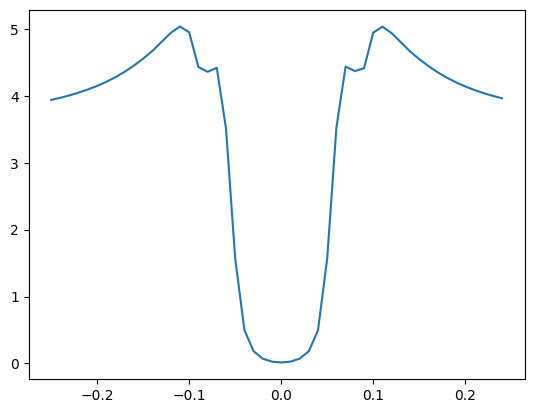

In [149]:
n_motional = 8       # Number of motional levels
Gamma = np.array([1e6 ,1e6]) # Spontaneous emission rate (Γ) in Hz
Delta0 = 10*Gamma[0]# red-detuning (Δ) in Hz
eta = np.array([0.05, -0.05])              #Lamb-dicke parameter
nu = 0.05*Gamma[0]

delta_values = np.arange(-0.25*Gamma[0] , 0.25*Gamma[0], 0.01*Gamma[0])

avg_n = np.zeros(len(delta_values))
Omegaval = np.sqrt(2*nu*Delta0)

for i, delta in enumerate(delta_values):
    Delta = np.array([Delta0, Delta0 + delta])
    Omega = np.array([Omegaval,Omegaval])
    ground1_pop_ss, ground2_pop_ss, excited_pop_ss, motional_n_ss = compute_ss(n_motional,nu,Delta,Gamma,eta, Omega, False) ## Used -Delta for red-detuned transitions.
    avg_n[i] = motional_n_ss  

plt.plot(delta_values/Gamma[0],(avg_n))

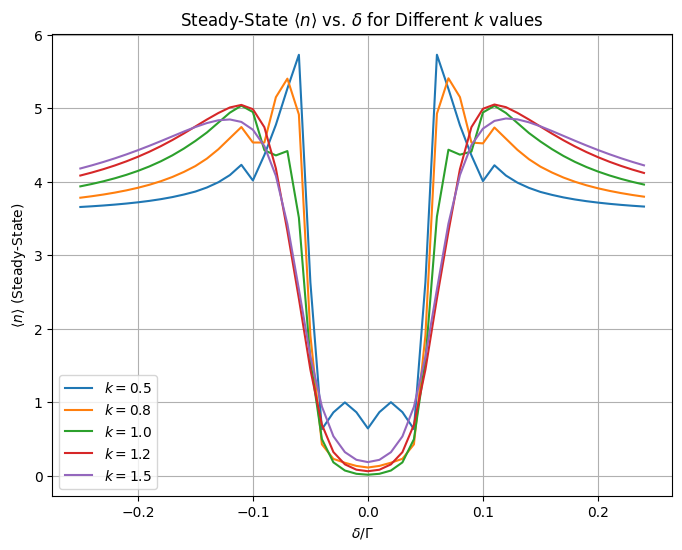

In [ ]:
# Scan around optimal cooling power: when omega^2/2Delta = nu (why?)

n_motional = 8  # Number of motional levels
Gamma = np.array([0.01 * 1e6, 0.01 * 1e6])  # Spontaneous emission rate (Γ) in Hz
Delta0 = 10 * Gamma[0]  # Red-detuning (Δ) in Hz
eta = np.array([0.05, -0.05])  # Lamb-Dicke parameter
nu = 0.05 * Gamma[0]  # Motional frequency

delta_values = np.arange(-0.25*Gamma[0] , 0.25*Gamma[0], 0.01*Gamma[0])

k_values = np.linspace(0.5,1.5, 5)  # Range of k values (modify as needed)
avg_n = np.zeros((len(k_values), len(delta_values)))

plt.figure(figsize=(8, 6))

for idx, k in enumerate(k_values):
    for i, delta in enumerate(delta_values):
        Delta = np.array([Delta0, Delta0 + delta])
        Omega = np.array([k*np.sqrt(2*nu*Delta0), k*np.sqrt(2*nu*Delta0)])
        ground1_pop_ss, ground2_pop_ss, excited_pop_ss, motional_n_ss = compute_ss(n_motional, nu, Delta, Gamma, eta, Omega, False) 
        avg_n[idx, i] = motional_n_ss  

    # Plot for each k
    plt.plot(delta_values / Gamma[0], avg_n[idx], label=rf'$k = {k:.1f}$')

# Formatting
plt.xlabel(r'$\delta / \Gamma$')
plt.ylabel(r'$\langle n \rangle$ (Steady-State)')
plt.title(r'Steady-State $\langle n \rangle$ vs. $\delta$ for Different $k$ values')
plt.legend()
plt.grid(True)

plt.show()


## $\Lambda$ - EIT with effective operator formalism:

In [36]:
def compute_ss_effective(n_motional, nu, Delta, Gamma, eta, Omega):
    """
    Compute steady state using effective operator formalism as shown in the equations.
    
    Parameters:
    - n_motional: dimension of motional Hilbert space
    - nu: trap frequency
    - Delta: array of detunings [Delta0, Delta1]
    - Gamma: array of decay rates [Gamma0, Gamma1]
    - eta: array of Lamb-Dicke parameters [eta0, eta1]
    - Omega: array of Rabi frequencies [Omega0, Omega1]
    - approx: if True, use approximation for small eta
    
    Returns:
    - Ground state populations and motional number expectation
    """
    
    # Common effective operator parameters from the image
    Omega0 = Omega[0]
    Omega1 = Omega[1]
    Omega_rms = np.sqrt(Omega0**2 + Omega1**2)
    
    # We assume Delta0 = Delta1 for large enough detuning.
    Delta_eff = Delta[0]
    
    # Calculate effective parameters
    Omega_r = (Omega0 * Omega1) / (2 * Delta_eff)  # Eq. 85
    
    # Operators
    a = qt.destroy(n_motional)          # Annihilation operator
    a_dag = qt.create(n_motional)       # Creation operator
    id_internal = qt.qeye(2)            # Identity for internal state (2-level effective system)
    id_motional = qt.qeye(n_motional)   # Identity for motional state
    
    # Position operator 
    x = (a + a_dag)
    
   
    # Basis states for effective 2-level system. |gB⟩ (bright state) corresponds to basis(2,0), |gD⟩ (dark state) corresponds to basis(2,1)
    bright_proj = qt.basis(2, 0).proj()
    dark_proj = qt.basis(2, 1).proj()
    
    #Writing down the effective Hamiltonian:
    H_motional = nu * qt.tensor(id_internal, a_dag * a)
    
    ac_stark_term = (Omega0**2 + Omega1**2) / (2 * Delta_eff) * qt.tensor(bright_proj, id_motional)
    
    coupling_term = Omega_r * 1j*eta*qt.tensor(
        qt.basis(2, 0) * qt.basis(2, 1).dag() , x)
    
    coupling_term = coupling_term + coupling_term.dag()  
    
    # Complete effective Hamiltonian
    H_eff = H_motional + ac_stark_term + coupling_term 
    
    # Bright and dark state projection operators
    D_B = qt.basis(2, 0)
    D_D = qt.basis(2, 1)

    # Projectors onto original ground states
    D0 = (Omega0*D_B - Omega1*D_D)/Omega_rms
    D1 = (Omega1*D_B + Omega0*D_D)/Omega_rms  

    D0 = qt.tensor(D0, id_motional)
    D1 = qt.tensor(D1, id_motional)
    
    # Collapse operators for bright and dark states
    gamma_r = Gamma*(Omega0**2 + Omega1**2)/(Delta_eff**2)

    plusRHS = qt.tensor(D_B.dag(), id_motional) + 1j*eta*qt.tensor(D_B.dag() + 2*Omega0*Omega1/(Omega_rms**2)*D_D.dag(), x)
    minusRHS = qt.tensor(D_B.dag(), id_motional) - 1j*eta* qt.tensor(D_B.dag() + 2*Omega0*Omega1/(Omega_rms**2)*D_D.dag(), x)

    Leff_0_plus = np.sqrt(gamma_r)*D0*plusRHS
    Leff_0_minus = np.sqrt(gamma_r)*D0*minusRHS
    Leff_1_plus = np.sqrt(gamma_r)*D1*plusRHS
    Leff_1_minus = np.sqrt(gamma_r)*D1*minusRHS

    c_ops = [Leff_0_plus, Leff_0_minus, Leff_1_plus, Leff_1_minus]  # List of collapse operators
    
    # Solve for steady state
    rho_ss = qt.steadystate(H_eff, c_ops)
    
    # Measurement operators for 2-level effective system
    measure_bright = qt.tensor(bright_proj, id_motional)
    measure_dark = qt.tensor(dark_proj, id_motional)
    measure_n = qt.tensor(id_internal, a_dag * a)
    
    # Compute steady-state expectation values
    bright_pop_ss = qt.expect(measure_bright, rho_ss)
    dark_pop_ss = qt.expect(measure_dark, rho_ss)
    motional_n_ss = qt.expect(measure_n, rho_ss)
    
    
    return bright_pop_ss, dark_pop_ss, motional_n_ss

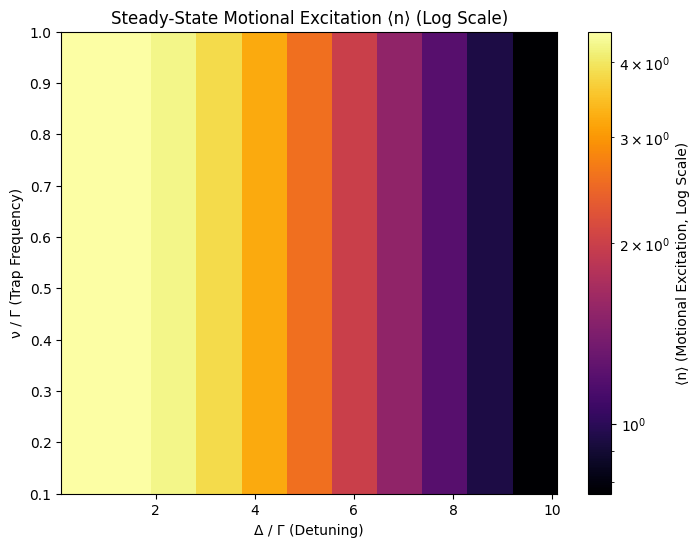

In [59]:
from matplotlib.colors import LogNorm

# Parameters
n_motional = 10      # Number of motional levels
Gamma = 1e6          # Spontaneous emission rate (Γ) in Hz
eta = 0.05           # Lamb-Dicke parameter

# Define parameter sweep ranges
delta_values = np.arange(0.1 * Gamma, (11) * Gamma, Gamma)  # Δ from 10Γ to 20Γ with step Γ
nu_values = np.arange(0.1*Gamma, 1.1 * Gamma, 0.1 * Gamma)               # ν from 0 to Γ with step 0.1Γ

# Create an empty 2D array to store avg_n results
avg_n = np.zeros((len(nu_values), len(delta_values)))

# Parameter sweep
for i, nu in enumerate(nu_values):
    for j, delta in enumerate(delta_values):
        Delta = np.array([delta, delta])
        Omegaval = np.sqrt(nu * delta)
        Omega = np.array([Omegaval, Omegaval])
        
        # Compute steady-state motional occupation number
        _, _,  motional_n_ss = compute_ss_effective(n_motional, nu, Delta, Gamma, eta, Omega)
        avg_n[i, j] = motional_n_ss  # Store result in 2D array

# Avoid zero values for log scale by setting a small floor value
avg_n[avg_n == 0] = 1e-6  

# Plot heatmap with log scale
plt.figure(figsize=(8, 6))
plt.imshow(avg_n, aspect='auto', origin='lower',
           extent=[delta_values[0]/Gamma, delta_values[-1]/Gamma, 
                   nu_values[0]/Gamma, nu_values[-1]/Gamma], 
           cmap='inferno', norm=LogNorm(vmin=avg_n.min(), vmax=avg_n.max()))

plt.colorbar(label="⟨n⟩ (Motional Excitation, Log Scale)")
plt.xlabel("Δ / Γ (Detuning)")
plt.ylabel("ν / Γ (Trap Frequency)")
plt.title("Steady-State Motional Excitation ⟨n⟩ (Log Scale)")
plt.show()


In [51]:
#Testing code, to sanity check the compute ss function

n_motional = 10         # Number of motional levels
Gamma = 1e6 # Spontaneous emission rate (Γ) in Hz
Delta = 10 * np.array([10*Gamma, 10*Gamma])  # Detuning (Δ) in Hz
nu = 0.05*Gamma # Trap frequency (ν) in Hz 

eta = 0.05              #Lamb-dicke parameter
# Eta removes the necessity for defining k because already given
Omega = np.sqrt(nu*Delta)
ground1_pop_ss, ground2_pop_ss, motional_n_ss = compute_ss_effective(n_motional,nu,Delta,Gamma,eta, Omega)


print("Steady-state excited population:", excited_pop_ss)
print("Steady-state ground1 population:", ground1_pop_ss)
print("Steady-state ground2 population:", ground2_pop_ss)
print("Steady-state average phonon number:", motional_n_ss)

# As expected, most of the population lies in ground2 i.e. dark state

Steady-state excited population: 0
Steady-state ground1 population: 0.00817685114892661
Steady-state ground2 population: 0.9918231488510733
Steady-state average phonon number: 0.021152310938981136
